# Style-based Generation with Transformers

In [1]:
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

In [2]:
data = pd.read_csv('../Data/data_styled.csv')
for col in ["chords", "style_s", "style_m", "style_l"]:
    data[col] = data[col].apply(lambda x: torch.tensor(json.loads(x)))
data.head()

,url,title,artist,decade,genre,ratings,stars,chords,style_s,style_m,style_l
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,"[tensor(648), tensor(640), tensor(648), tensor...","[tensor(-0.2223), tensor(-2.5232), tensor(-0.4...","[tensor(-1.1219), tensor(0.3953), tensor(-1.06...","[tensor(-0.0928), tensor(0.3050), tensor(-3.47..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,"[tensor(155), tensor(31), tensor(648), tensor(...","[tensor(-0.7795), tensor(-3.5220), tensor(0.18...","[tensor(-0.7120), tensor(0.8121), tensor(-2.26...","[tensor(0.3834), tensor(-0.2047), tensor(-3.91..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,"[tensor(648), tensor(155), tensor(640), tensor...","[tensor(-1.1052), tensor(-2.8153), tensor(-0.5...","[tensor(-1.8191), tensor(-1.4919), tensor(-2.0...","[tensor(0.2651), tensor(0.1635), tensor(-3.742..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,"[tensor(166), tensor(403), tensor(380), tensor...","[tensor(0.1859), tensor(-2.8610), tensor(-0.73...","[tensor(-1.4147), tensor(-0.0339), tensor(-0.8...","[tensor(0.4739), tensor(0.6764), tensor(-4.274..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,"[tensor(155), tensor(78), tensor(648), tensor(...","[tensor(1.1328), tensor(-3.2465), tensor(-0.14...","[tensor(-0.8233), tensor(1.1983), tensor(0.155...","[tensor(0.7397), tensor(0.6211), tensor(-3.752..."


In [3]:
augmentation_map = torch.tensor(np.load('../Data/augmentation_map.npy', allow_pickle=True))

with open("../Data/token_to_chord.json", "r") as f:
    token_to_chord = json.load(f)

In [4]:
VOCAB_SIZE = len(token_to_chord) + 2 # Start and end of sequence tokens
VOCAB_SIZE

975

In [5]:
STYLE_COL, STYLE_DIM = "style_s", 64

d:\Programs\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
d:\Programs\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
d:\Programs\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
d:\Programs\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


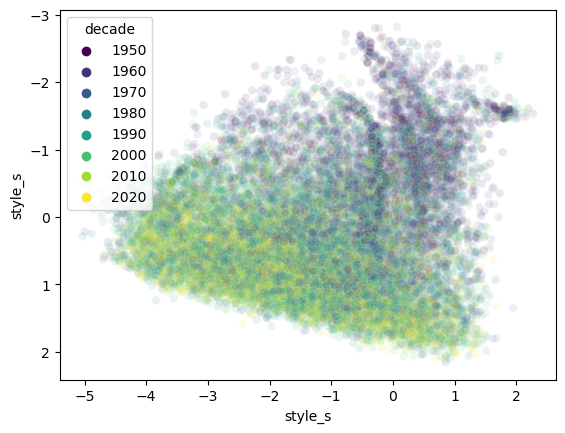

In [6]:
# Visualize the styles and their decade
dims = np.arange(STYLE_DIM)
np.random.shuffle(dims)
x_dim, y_dim = dims[0], dims[1]

sns.scatterplot(
    x=data[STYLE_COL].apply(lambda x: x[x_dim]),
    y=data[STYLE_COL].apply(lambda y: y[y_dim]),
    hue=data["decade"],
    legend="full",
    palette="viridis",
    alpha=0.1
)
plt.show()

## Dataset

In [7]:
class ChordDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def augment(self, chords):
        """Change the root note of the chords by a random amount"""
        move_by = torch.randint(0, 12, [1]).item()
        return augmentation_map[chords, move_by]
        
    def pad(self, chords):
        """Pad the input 2D tensor [n] into shape [256] with zeros"""
        out = torch.zeros((256))
        out[0] = VOCAB_SIZE - 2 # Start of sequence token
        out[1:len(chords) + 1] = chords
        out[len(chords) + 1] = VOCAB_SIZE - 1 # End of sequence token
        return out

    def __getitem__(self, index):
        row = self.data.iloc[index]
        x = self.augment(row["chords"])
        x = self.pad(x).long()
        style = row[STYLE_COL]
        
        return x, style

    def __len__(self):
        return len(self.data)

In [8]:
torch.manual_seed(42)

dataset = ChordDataset(data)
train_size = np.rint(len(dataset) * 0.8).astype(int)
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [9]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

## Model

In [10]:
class AdaptiveLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.gain = nn.Linear(d_model, d_model)
        self.bias = nn.Linear(d_model, d_model)            
        
    def forward(self, x, style):
        gain = self.gain(F.relu(style)).unsqueeze(1).repeat(1, x.shape[1], 1)
        bias = self.bias(F.relu(style)).unsqueeze(1).repeat(1, x.shape[1], 1)
        return (1 + gain) * self.norm(x) + bias
                 

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.layer_norm1 = AdaptiveLayerNorm(d_model)
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=n_heads, batch_first=True
        )
        self.dropout1 = nn.Dropout(0.1)
        self.layer_norm2 = AdaptiveLayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model)
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, style, mask=None):
        # Multi-head attention
        att_input = self.layer_norm1(x, style)
        att_output = self.multi_head_attention(att_input, att_input, att_input, attn_mask=mask, need_weights=False)[0]
        x = x + self.dropout1(att_output)

        # Feed forward
        ff_input = self.layer_norm2(x, style)
        ff_output = self.feed_forward(ff_input)
        x = x + self.dropout2(ff_output)
        
        return x 


class StyleTransformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, input_len):
        super().__init__()
        self.style_map = nn.Sequential(nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model))
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_layers)])
        self.output = nn.Linear(d_model, VOCAB_SIZE)

        # Positional encoding
        self.register_buffer('pe', torch.zeros(input_len, d_model))
        self.pe = torch.zeros(input_len, d_model)
        pos = torch.arange(0, input_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        self.pe[:, 0::2] = torch.sin(pos * div_term)
        self.pe[:, 1::2] = torch.cos(pos * div_term)
        
    def generate_square_subsequent_mask(self, size):
        """Generate a mask to avoid using future tokens."""
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def forward(self, x, style):
        x = self.embedding(x)
        style = self.style_map(style)
        x = x + self.pe
        
        # Generate mask
        mask = self.generate_square_subsequent_mask(x.size(1)).to(x.device)
        
        # Passing through all transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, style, mask)
        x = self.output(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The architecture and the hyperparameters are the same as in the Conditional Transformer, except that we feed the style instead of the genre and decade vector as the condition.

In [12]:
style_transformer = StyleTransformer(
    d_model=64,
    n_heads=8,
    n_layers=6,
    input_len=256
).to(device)
dummy_input = torch.zeros((1, 256), dtype=torch.long).to(device)
dummy_style = torch.zeros((1, STYLE_DIM)).to(device)
summary(style_transformer, input_data=(dummy_input, dummy_style))

d:\Programs\anaconda3\lib\site-packages\torch\nn\modules\activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                   Output Shape              Param #
StyledTransformer                        [1, 256, 975]             --
├─Embedding: 1-1                         [1, 256, 64]              62,400
├─Sequential: 1-2                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 64]                   4,160
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-4             [1, 256, 64]              --
│    │    └─AdaptiveLayerNorm: 3-1       [1, 256, 64]              8,448
│    │    └─MultiheadAttention: 3-2      [1, 256, 64]              16,640
│    │    └─Dropout: 3-3                 [1, 256, 64]              --
│    │    └─AdaptiveLayerNorm: 3-4       [1, 256, 64]              8,448
│    │    └─Sequential: 3-5              [1, 256, 64]            

## Trainer

In [13]:
class Trainer():
    def __init__(self, epochs, train_loader, test_loader, model, optimizer, one_hot_criterion, device, lr_scheduler):
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.optimizer = optimizer
        self.one_hot_criterion = one_hot_criterion
        self.device = device
        self.print_every = 16
        self.lr_scheduler = lr_scheduler
        
        self.step_data = {"train_losses": [], "test_losses": [],  "train_accuracies": [], "test_accuracies": []}
        self.epoch_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
    

    def loss_mask(self, y_pred, x):
        """Get the mask for the loss function"""
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        mask = range_tensor <= eos_index.unsqueeze(1)
        return mask
    
    def masked_accuracy(self, y_pred, x):
        """Calculate the accuracy of the model for elements of the sequence"""
        y_pred, x = y_pred[:, :-1], x[:, 1:]
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        # EOS is not included in the accuracy calculation
        mask = range_tensor < eos_index.unsqueeze(1)
        valid_elements = torch.sum(mask.float())

        same = torch.argmax(y_pred, dim=2) == x
            
        return torch.sum(same.float() * mask.float()) / valid_elements
    
    def masked_cross_entropy(self, logits, target, mask):
        """
        logits: Predictions from the model, of shape (batch_size, sequence_length, num_classes)
        target: Ground truth labels, of shape (batch_size, sequence_length)
        mask: Binary mask indicating the non-padded parts, of shape (batch_size, sequence_length)
        """
        # Flatten all the dimensions except for the classes dimension
        logits_flat = logits.reshape(-1, logits.size(-1))
        target_flat = target.reshape(-1)
        mask_flat = mask.reshape(-1).float()
        
        # Compute the CrossEntropyLoss
        loss = nn.CrossEntropyLoss(reduction='none')(logits_flat, target_flat)
        
        # Apply the mask to the loss
        masked_loss = loss * mask_flat
        
        # Compute the mean loss over non-padded parts
        final_loss = masked_loss.sum() / mask_flat.sum()
        
        return final_loss

    
    def train_step(self):
        self.model.train()
        for i, (x, style) in enumerate(self.train_loader):
            x, style = x.to(self.device), style.to(self.device)
            y_pred = self.model(x, style)
            mask = self.loss_mask(y_pred, x)
            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["train_losses"].append(loss.item())
            self.step_data["train_accuracies"].append(self.masked_accuracy(y_pred, x).item())

            if i % self.print_every == self.print_every - 1:
                print(f"Batch {i + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}, Accuracy: {self.step_data['train_accuracies'][-1]:.4f}")
                            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        self.epoch_data["train_losses"].append(np.array(self.step_data["train_losses"]).mean())
        self.epoch_data["train_accuracies"].append(np.array(self.step_data["train_accuracies"]).mean())
                   
        
    def eval_step(self):
        self.model.eval()
        for i, (x, style) in enumerate(self.train_loader):
            x, style = x.to(self.device), style.to(self.device)
            with torch.inference_mode():
                y_pred = self.model(x, style)

            mask = self.loss_mask(y_pred, x)            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["test_losses"].append(loss.item())
            self.step_data["test_accuracies"].append(self.masked_accuracy(y_pred, x).item())
        
        self.epoch_data["test_losses"].append(np.array(self.step_data["test_losses"]).mean())
        self.epoch_data["test_accuracies"].append(np.array(self.step_data["test_accuracies"]).mean())
                    
        
        print(f"Test Loss: {loss.item():.4f},  Accuracy: {self.step_data['test_accuracies'][-1]:.4f}")

    def plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        axes[0].set_title("Loss")
        sns.lineplot(x=range(len(self.epoch_data["train_losses"])), y=self.epoch_data["train_losses"], label="Train Loss", ax=axes[0])
        sns.lineplot(x=range(len(self.epoch_data["test_losses"])), y=self.epoch_data["test_losses"], label="Test Loss", ax=axes[0])
        
        axes[1].set_title("Total Accuracy")
        sns.lineplot(x=range(len(self.epoch_data["train_accuracies"])), y=self.epoch_data["train_accuracies"], label="Train Accuracy", ax=axes[1])
        sns.lineplot(x=range(len(self.epoch_data["test_accuracies"])), y=self.epoch_data["test_accuracies"], label="Test Accuracy", ax=axes[1])
        
    
    def init_metrics(self):
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}

        
    def train(self):    
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}\n-------------------------------")
            self.init_metrics()
            self.train_step()
            self.eval_step()
            self.lr_scheduler.step()
            
        self.plot()

## Training

In [14]:
one_hot_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(style_transformer.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
trainer = Trainer(
    epochs=50,
    train_loader=train_loader,
    test_loader=test_loader,
    model=style_transformer,
    optimizer=optimizer,
    one_hot_criterion=one_hot_criterion,
    device=device,
    lr_scheduler=lr_scheduler,
)

Epoch 1/50
-------------------------------
Batch 16/139, Loss: 3.3888, Accuracy: 0.2565
Batch 32/139, Loss: 2.8494, Accuracy: 0.3147
Batch 48/139, Loss: 2.4398, Accuracy: 0.3402
Batch 64/139, Loss: 2.2847, Accuracy: 0.3502
Batch 80/139, Loss: 2.4842, Accuracy: 0.3378
Batch 96/139, Loss: 2.2958, Accuracy: 0.3763
Batch 112/139, Loss: 2.2486, Accuracy: 0.3591
Batch 128/139, Loss: 2.2230, Accuracy: 0.3739
Test Loss: 1.8247,  Accuracy: 0.4227
Epoch 2/50
-------------------------------
Batch 16/139, Loss: 1.9796, Accuracy: 0.4117
Batch 32/139, Loss: 1.8953, Accuracy: 0.4283
Batch 48/139, Loss: 1.9477, Accuracy: 0.4000
Batch 64/139, Loss: 2.0794, Accuracy: 0.3989
Batch 80/139, Loss: 1.8856, Accuracy: 0.4224
Batch 96/139, Loss: 2.1401, Accuracy: 0.3876
Batch 112/139, Loss: 1.9057, Accuracy: 0.4028
Batch 128/139, Loss: 2.1709, Accuracy: 0.3798
Test Loss: 1.9553,  Accuracy: 0.4180
Epoch 3/50
-------------------------------
Batch 16/139, Loss: 1.9030, Accuracy: 0.4168
Batch 32/139, Loss: 1.7890, 

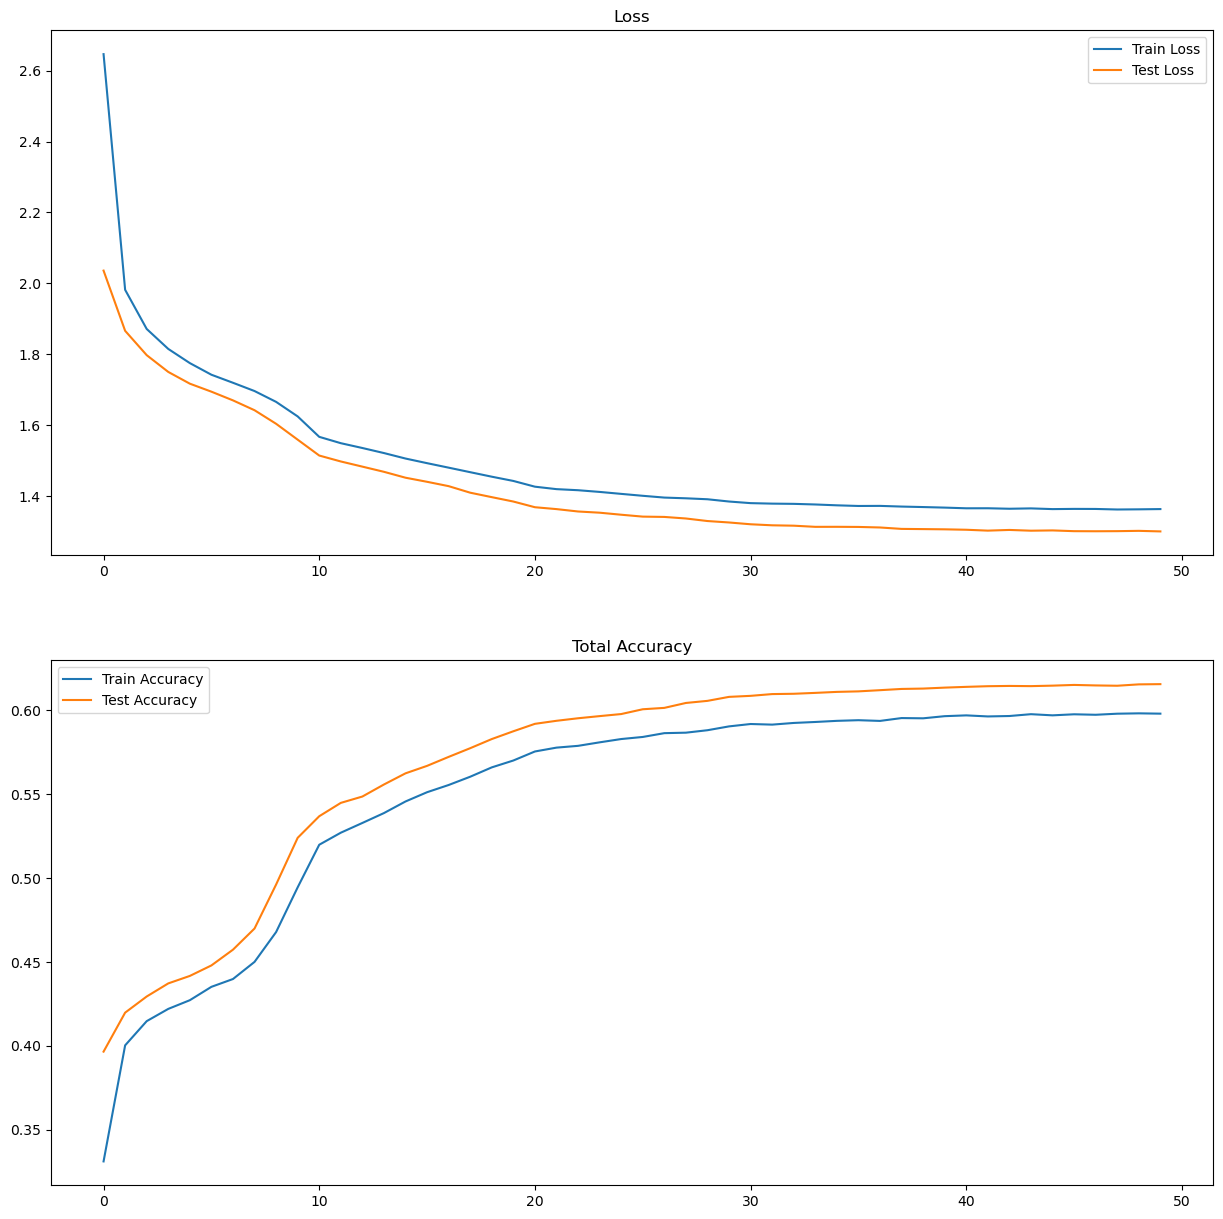

In [15]:
trainer.train()

In [16]:
# Save the model
torch.save(style_transformer.state_dict(), "../Models/StyleTransformerS.pt")

## Inference

In [17]:
from src import *

parser = chord_parser.Main()
interpreter = seq_interpreter.Main(parser)

In [18]:
from scipy.stats import gaussian_kde

samples = np.array(data[STYLE_COL].apply(lambda x: x.tolist()).tolist())
# The bw value is derived from visual inspection to strike a balance between smoothness and accuracy
kde = gaussian_kde(samples.T, bw_method=0.05)

In [19]:
def pad(chords):
    """Pad the input 2D tensor [n] into shape [256] with zeros"""
    out = torch.zeros((256))
    out[0] = VOCAB_SIZE - 2 # Start of sequence token
    out[1:len(chords) + 1] = chords
    return out

In [20]:
def generate_sequence(temperature, max_length):
    style_transformer.eval()
    with torch.inference_mode():
        x = torch.zeros((1, max_length + 1), dtype=torch.long, device=device)
        
        # Sample the style from the KDE
        style = torch.tensor(kde.resample(1), dtype=torch.float32).T
        for i in range(max_length):
            input_x = x[:, :i].squeeze(0)
            input_x = pad(input_x).long().unsqueeze(0)
            y_pred = style_transformer(input_x.to(device), style.to(device)).squeeze()[i]
            # Zero out the probability for the same as the previous chord
            if i > 0:
                y_pred[x[:, i - 1]] = -torch.inf
            # Sample from the distribution
            y_pred = F.softmax(y_pred, dim=0) ** (1 / temperature)
            x[:, i] = y_pred.multinomial(1).item()
            if x[:, i] == VOCAB_SIZE - 1:
                break

    return x[0, :-1]

In [21]:
seq = generate_sequence(1.0, 254)
print(interpreter.token_seq_to_chords(seq))
interpreter.play_seq(seq)

d:\Programs\anaconda3\lib\site-packages\torch\nn\modules\activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


C# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | C# | G# | A#m | F# | G# | A#m | F# | G# | C# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | F# | G# | A#m | F# | G# | A#m | F# | G# | C# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | C# | F# | G# | A#m | F# | G# | C# | G# | A#m | F# | C# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | A#m | F# | G# | F#maj7
